In [1]:
#export
import numpy as np
import pandas as pd
import os

from fastai.text import *
from fastai import *

# Language Model with label smoothing

In [2]:
path = Path('/home/jupyter/insight_project/Project-M/data/preprocessed/csv')

In [3]:
filenames = path.ls()
len(filenames)

72

In [57]:
dfs = []
i=0
for file in filenames:
    if file.name == 'models': continue
    df = pd.read_csv(file)
    df['user'] = i
    i = i+1 
    dfs.append(df)

df_total = pd.concat(dfs)

In [59]:
df_total.tail()

,Body,Label,Source,user
78,"Surprisingly, it looks like Kalustyan's [doesn...",1,reddit,70
79,"i also like this this type of product , u can ...",1,twitter,70
80,ZIPPYAR CPG enables brands to stream their vid...,0,twitter,70
81,"Per number two, I think the idea that external...",0,reddit,70
82,The only vehicle I can afford is an old fuel i...,1,reddit,70


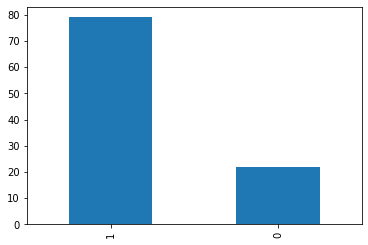

In [56]:
dfs[0]['Label'].value_counts().plot(kind='bar')

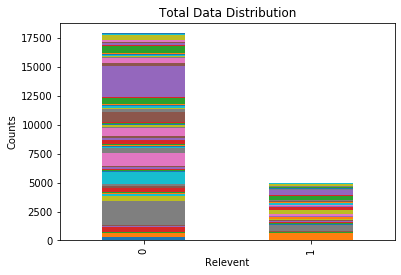

In [65]:
ax = df_total.groupby(['Label','user']).size().unstack().plot(kind='bar',stacked=True,
                                                         legend=False,title='Total Data Distribution'
                                                        )
ax.set(xlabel='Relevent', ylabel='Counts')
plt.show()

In [5]:
df_total['Label'].value_counts()

0    17911
1     4976
Name: Label, dtype: int64

In [15]:
df_total.iloc[400]['Body']

'But I think tick is easier than nita\n\nI push tick mostly in duo sd and brawl ball (tick jist need to support teammate and i get 500 tick in lv 3)'

In [6]:
txt_proc = [
    OpenFileProcessor(),
    TokenizeProcessor(),
    NumericalizeProcessor(min_freq=2)
]

In [7]:
data_lm = (TextList
           .from_df(df_total,path=path,processor=txt_proc)
           .split_by_rand_pct(0.1)
           .label_for_lm()
           .databunch(bs=64,num_workers=os.cpu_count()*4)
          )

# Pre-processing:
* pre_rules:
* post_rules:

In [38]:
pd.set_option('display.max_colwidth', -1)

Original text and after pre-processing / tokenized text

In [84]:
data_lm.train_ds.x.inner_df.iloc[140]['Body']

'Therefore application servers as minimum environment still makes sense in development environment. But Kubernetes and other orchestrators make sense in production env. https://t.co/H6AMOZWfav'

In [85]:
data_lm.train_ds[140]

(Text xxbos xxmaj therefore application servers as minimum environment still makes sense in development environment . xxmaj but xxmaj kubernetes and other xxunk make sense in production env . https : / / t.co / xxunk,
 EmptyLabel )

In [87]:
data_lm.train_ds.x.inner_df.iloc[570]['Body']

'Best Gyms Near Me With Personal Trainers --   \n\nIf you love your body then go to the gym to get the perfect shape. Find the best gym and fitness centers with personal trainers near you with Fitsapp.\n\nClick the Link to Download the App:  [https://play.google.com/store/apps/details?id=in.fitsapp.sheliza.fitsapp](https://play.google.com/store/apps/details?id=in.fitsapp.sheliza.fitsapp)'

In [88]:
data_lm.train_ds[570]

(Text xxbos xxmaj best xxmaj gyms xxmaj near xxmaj me xxmaj with xxmaj personal xxmaj trainers -- 
  
   xxmaj if you love your body then go to the gym to get the perfect shape . xxmaj find the best gym and fitness centers with personal trainers near you with xxmaj fitsapp . 
  
   xxmaj click the xxmaj link to xxmaj download the xxmaj app : [ https : / / play.google.com / store / apps / details?id = in.fitsapp.sheliza.fitsapp](https : / / play.google.com / store / apps / details?id = in.fitsapp.sheliza.fitsapp ),
 EmptyLabel )

In [93]:
data_lm.vocab.stoi['in.fitsapp.sheliza.fitsapp']

13839

In [94]:
data_lm.save(path/'models/data_lm_large.pkl')

In [16]:
data_lm = load_data(path/'models','data_lm_large.pkl',bs=64)

In [8]:
loss_func = FlattenedLoss(LabelSmoothingCrossEntropy)

In [9]:
learn = language_model_learner(data_lm,AWD_LSTM,loss_func=loss_func,drop_mult=0.3)

In [10]:
learn.to_fp16()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-02
Min loss divided by 10: 1.74E-02


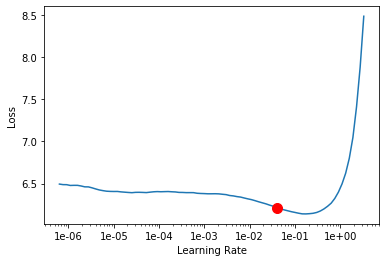

In [11]:
learn.recorder.plot(suggestion=True)

In [12]:
learn.fit_one_cycle(1,1e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.009421,4.856063,0.325057,02:44


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 9.12E-04


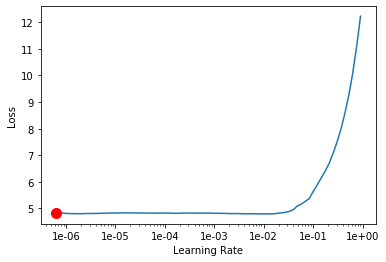

In [13]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [17]:
learn.fit_one_cycle(10,1e-3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.032220,5.105643,0.335762,02:55
1,4.647974,4.786225,0.356068,02:54
2,4.464023,4.635537,0.375961,02:54
3,4.246868,4.529159,0.391695,02:55
4,4.073252,4.453542,0.404121,02:56
5,3.887814,4.418527,0.413021,02:56
6,3.781201,4.404501,0.419118,02:56
7,3.684335,4.392826,0.424247,02:57
8,3.588093,4.397166,0.426759,02:58
9,3.445781,4.399778,0.426860,02:58


In [18]:
learn.save('fine-tuned-large-fwd')

In [22]:
learn.to_fp32().save(path/'models/fine-tuned-fwd',with_opt=False)
learn.save_encoder(path/'models/fine-tuned-enc-fwd')

In [23]:
!ls {path}/'models'

1a.pth			    data_lm.pkl		    models
awd_lstm_baseline-0917.pth  fine-tuned-enc-fwd.pth  textlist_class_seed42
data_lm_large.pkl	    fine-tuned-fwd.pth	    tmp.pth


# Backward language model

In [19]:
txt_proc = [
    OpenFileProcessor(),
    TokenizeProcessor(),
    NumericalizeProcessor(min_freq=2)
]

In [20]:
data_lm = (TextList
           .from_df(df_total,path=path,processor=txt_proc)
           .split_by_rand_pct(0.1)
           .label_for_lm()
           .databunch(bs=64,num_workers=os.cpu_count()*4,backwards=True)
          )

In [24]:
data_lm.save(path/'models/data_lm_large_bwd.pkl')

In [25]:
data_lm = load_data(path/'models/','data_lm_large_bwd.pkl',bs=64,backwards=True)

In [26]:
loss_func = FlattenedLoss(LabelSmoothingCrossEntropy)
learn = language_model_learner(data_lm,AWD_LSTM,loss_func=loss_func,drop_mult=0.5).to_fp16()

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-02
Min loss divided by 10: 1.74E-02


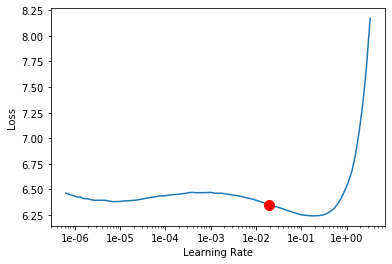

In [28]:
learn.recorder.plot(suggestion=True)

In [30]:
lr = 1e-2

In [32]:
learn.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.118210,4.907674,0.343916,02:43
1,4.803553,4.743691,0.366969,02:44


In [33]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [37]:
learn.fit_one_cycle(10, lr/10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.484398,4.646111,0.385035,03:02
1,4.378865,4.549836,0.405811,03:02
2,4.331396,4.462442,0.423397,03:02
3,4.208072,4.401680,0.435429,03:02
4,4.067045,4.355118,0.445166,03:03
5,3.920295,4.328608,0.452619,03:03
6,3.804653,4.310792,0.457527,03:03
7,3.773977,4.302506,0.461235,03:03
8,3.674109,4.300546,0.462647,03:03
9,3.543531,4.301922,0.462994,03:03


In [38]:
learn.to_fp32().save(path/'models/fine-tuned-bwd',with_opt=False)
learn.save_encoder(path/'models/fine-tuned-enc-bwd')

In [40]:
!ls {path}/models

1a.pth			    data_lm.pkl		    fine-tuned-fwd.pth
awd_lstm_baseline-0917.pth  fine-tuned-bwd.pth	    models
data_lm_large_bwd.pkl	    fine-tuned-enc-bwd.pth  textlist_class_seed42
data_lm_large.pkl	    fine-tuned-enc-fwd.pth  tmp.pth


# Classifier - FWD

In [19]:
filenames.remove(Path('/home/jupyter/insight_project/Project-M/data/preprocessed/csv/models'))
len(filenames)

71

In [20]:
import random

random.seed(42)
random.shuffle(filenames)
 
def _train_valid_split(total_filenames,train_pct=0.7):
    '''split the train and test base on total datasets
        return train_list and valid_list with their associated path'''

    split_point = round(len(total_filenames)*train_pct)
    assert (type(split_point) == int)
    return total_filenames[:split_point],total_filenames[split_point:]

def _get_df_from_filenames(filenames):
    '''pass a list of filenames, return df of total'''
    
    dfs = []
    for file in filenames:
        df = pd.read_csv(file)
        dfs.append(df)

    df_total = pd.concat(dfs)
    return df_total

In [21]:
train_list, valid_list = _train_valid_split(filenames)
df_train = _get_df_from_filenames(train_list)
df_train['Label'].value_counts()

0    11599
1     3472
Name: Label, dtype: int64

In [43]:
!ls {path}/'models'

1a.pth			    data_lm.pkl		    fine-tuned-fwd.pth
awd_lstm_baseline-0917.pth  fine-tuned-bwd.pth	    models
data_lm_large_bwd.pkl	    fine-tuned-enc-bwd.pth  textlist_class_seed42
data_lm_large.pkl	    fine-tuned-enc-fwd.pth  tmp.pth


In [150]:
data_lm = load_data(path/'models','data_lm_large.pkl',bs=64)

In [17]:
data_lm.vocab.stoi['this']

34

In [22]:
data = (TextList
        .from_df(df=df_train,path=path,cols='Body',vocab=data_lm.vocab)
        .split_by_rand_pct(0.1,seed=42)
        .label_from_df(cols='Label')
        .databunch(bs=64,num_workers=os.cpu_count()*4)
       )

In [47]:
data.vocab.stoi['bigquery']

2801

In [52]:
data.train_ds.inner_df.iloc[17]['Body']

'From user-defined functions to increased concurrency limits, here’s how @GCPCloud’s new #BigQuery features are helping developers get more out of their data → https://t.co/e4LtucV4ke'

In [44]:
data.train_ds[14][0]

Text xxbos xxmaj damn that does sound like a textbook clusterfuck . xxmaj one thing i did in a similar situation is to try and pool data into one that is modern ( xxmaj google bigquery in this case ) and then go from there .

In [53]:
data.train_ds.inner_df.iloc[17]['Label']

0

In [48]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1))

In [49]:
loss_func = FlattenedLoss(LabelSmoothingCrossEntropy)

In [50]:
learn = text_classifier_learner(data,AWD_LSTM,drop_mult=0.5,
                                loss_func=loss_func,
                                metrics=[accuracy,f1], #FBeta(beta=1)
                                model_dir = path/'models'
                               ).to_fp16()

In [51]:
learn.load_encoder('fine-tuned-enc-fwd');

In [52]:
learn.freeze_to(-1);

In [53]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.09E-01
Min loss divided by 10: 4.37E-02


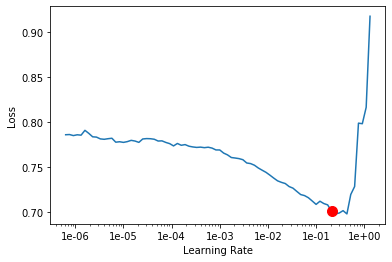

In [54]:
learn.recorder.plot(suggestion=True)

In [55]:
lr = 4e-2 * 64/48
moms = (0.8,0.7)
learn.fit_one_cycle(2,lr,moms=moms)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.527126,0.546029,0.783484,0.134762,00:46
1,0.528995,0.503052,0.804632,0.366207,00:42


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: Undefined

In [56]:
learn.fit_one_cycle(2,lr,moms=moms)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.529456,0.576486,0.796072,0.241808,00:45
1,0.513955,0.513662,0.801108,0.404948,00:47


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: Undefined

In [61]:
learn.save('1a')

In [58]:
learn.freeze_to(-2)
learn.fit_one_cycle(2,slice(lr/(2.6**4),lr),moms=moms)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.517295,0.564002,0.809668,0.423004,00:48
1,0.483015,0.990304,0.825277,0.488641,00:58


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [60]:
learn.freeze_to(-3)
learn.fit_one_cycle(2,slice(lr/2/(2.6**4),lr),moms=moms)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.509142,1.192296,0.815710,0.376608,01:02
1,0.461672,0.555004,0.847936,0.560861,01:02


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [64]:
learn.unfreeze()
learn.fit_one_cycle(1,slice(lr/10/(2.6**4),lr/10),moms=moms)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.436994,0.854883,0.844411,0.585876,01:13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [65]:
learn.save('general-clasifier-0.84')

In [66]:
!ls {path}/models

1a.pth			    fine-tuned-bwd.pth		models
awd_lstm_baseline-0917.pth  fine-tuned-enc-bwd.pth	textlist_class_seed42
data_lm_large_bwd.pkl	    fine-tuned-enc-fwd.pth	tmp.pth
data_lm_large.pkl	    fine-tuned-fwd.pth
data_lm.pkl		    general-clasifier-0.84.pth


In [151]:
def _get_individual_data(filepath):
    df = pd.read_csv(filepath)
    if df.shape[0]*0.7 < 64: 
        bs= int(df.shape[0]*0.7)
    else: bs=64
    data = (TextList
            .from_df(df=df,path=path,cols='Body',vocab=data_lm.vocab)
            .split_by_rand_pct(0.3,seed=42)
            .label_from_df(cols='Label')
            .databunch(bs=bs,num_workers=os.cpu_count()*4)
           )
    return data

def _get_individual_learner(data):
    learn = text_classifier_learner(data,AWD_LSTM,drop_mult=0.5,
                                loss_func=FlattenedLoss(LabelSmoothingCrossEntropy),
                                metrics=[accuracy], #FBeta(beta=1)
                                model_dir = path/'models'
                               )
    if torch.cuda.is_available():
        learn.to_fp16()
    learn.load('general-clasifier-0.84')
    learn.freeze_to(-1)
    return learn

def run_valid(data_path):
    _data_valid = _get_individual_data(data_path)
    _learn_valid = _get_individual_learner(_data_valid)
    _learn_valid.fit_one_cycle(1,1e-1,moms=(0.8,0.7))
    return _learn_valid.recorder.metrics[0][0].item()

In [152]:
%%time
valid_acc = []
for file in valid_list:
    valid_acc.append(run_valid(file))

epoch,train_loss,valid_loss,accuracy,time
0,0.373402,0.293208,0.959799,00:05


CPU times: user 1min 13s, sys: 1min 12s, total: 2min 26s
Wall time: 2min 26s


In [70]:
valid_acc

[0.6666666865348816,
 0.9583333134651184,
 0.7407407164573669,
 0.6153846383094788,
 0.8148148059844971,
 0.59375,
 0.6315789222717285,
 0.9487179517745972,
 0.7999999523162842,
 0.5,
 1.0,
 0.7948718070983887,
 0.5714285969734192,
 0.5769230723381042,
 0.9545454382896423,
 0.8160919547080994,
 0.8571428656578064,
 0.6428571939468384,
 0.9206349849700928,
 0.9459459185600281,
 0.9597989916801453]

In [71]:
sum(valid_acc) / 21

0.7766775148255485

# Compare with Basilica baseline

In [76]:
valid_list[0].name.split('.')[0]

'2a0a1cf7-29c1-4459-ab85-b57ed06386a7'

In [74]:
valid_list[0]

PosixPath('/home/jupyter/insight_project/Project-M/data/preprocessed/csv/2a0a1cf7-29c1-4459-ab85-b57ed06386a7.csv')

In [79]:
test_path = Path('/home/jupyter/insight_project/Project-M/data/raw/' 
                 + valid_list[0].name.split('.')[0]
                 + '.json'
                )

In [80]:
test_path

PosixPath('/home/jupyter/insight_project/Project-M/data/raw/2a0a1cf7-29c1-4459-ab85-b57ed06386a7.json')

In [84]:
def get_json_valid(valid_lists):
    json_path = []
    for path in valid_lists:
        json_path.append(Path('/home/jupyter/insight_project/Project-M/data/raw/'
                              + path.name.split('.')[0]
                              + '.json')
                        )
    return json_path

In [85]:
json_list = get_json_valid(valid_list)

In [88]:
import json
import sklearn.decomposition
import sklearn.linear_model
import sklearn.preprocessing

In [89]:
def data_point_features(data_point):
    return data_point['embedding'] + source_features(data_point['source'])

def source_features(source):
    return [int(source == 'hn'), int(source == 'reddit'), int(source == 'twitter'),
            int(source not in ['hn', 'reddit', 'twitter'])]

In [93]:
test_score_basilica = []
def quick_run(obj):   
    random.seed(120)
    random.shuffle(obj['data_points'])
    features = []
    labels = []
    for data_point in obj['data_points']:
        features.append(data_point_features(data_point))
        labels.append(data_point['label'])
    train_sz = int(len(features)*0.7)
    print('  Splitting into train (%s) and test (%s)....' % (
        train_sz, len(features) - train_sz))
    train_features = features[:train_sz]
    train_labels = labels[:train_sz]
    test_features = features[train_sz:]
    test_labels = labels[train_sz:]
    # if 0 in train_labels and 1 in train_labels:
    #     break
    print('  Preprocessing features...')
    fixed_train_features = (np.array(train_features))
    fixed_test_features = (np.array(test_features))
        # We scale the features to have mean 0 and unit standard
        # deviation.  We always want mean 0 to stop us from wasting the
        # first PCA component.  Scaling the standard deviations is more
        # questionable, it might be worth experimenting with removing
        # that.
    scaler = sklearn.preprocessing.StandardScaler(with_std=True)
    fixed_train_features = scaler.fit_transform(fixed_train_features)
    fixed_test_features = scaler.transform(fixed_test_features)
        # If we have a small number of data points, PCA down to half the
        # number of data points.  The exact PCA size here could probably
        # be tweaked, and I'm not sure whether or not whitening is
        # correct.
    pca_size = min(len(train_features)/2, len(train_features[0]))
    pca = sklearn.decomposition.PCA(n_components=int(pca_size), whiten=True)
    fixed_train_features = pca.fit_transform(fixed_train_features)
    fixed_test_features = pca.transform(fixed_test_features)

    print('  Training model...')
        # We train a bog-standard logistic regression, and it works fairly
        # well.
    classifier = sklearn.linear_model.LogisticRegression()
    classifier.fit(fixed_train_features, np.array(train_labels))
    train_score = classifier.score(fixed_train_features, np.array(train_labels))
    test_score = classifier.score(fixed_test_features, np.array(test_labels))

    print('  Train score: %s.' % train_score)
    print('  Test score: %s.' % test_score)
    test_score_basilica.append(test_score)

In [94]:
%%time
for json_path in json_list:
    with open(json_path) as f:
        obj = json.load(f)
        quick_run(obj)
test_score_basilica

  Splitting into train (58) and test (25)....
  Preprocessing features...
  Training model...
  Train score: 0.8620689655172413.
  Test score: 0.72.
  Splitting into train (56) and test (25)....
  Preprocessing features...
  Training model...
  Train score: 1.0.
  Test score: 0.96.
  Splitting into train (65) and test (28)....
  Preprocessing features...
  Training model...
  Train score: 0.9846153846153847.
  Test score: 0.9285714285714286.
  Splitting into train (91) and test (39)....
  Preprocessing features...
  Training model...
  Train score: 1.0.
  Test score: 0.7948717948717948.
  Splitting into train (63) and test (28)....
  Preprocessing features...
  Training model...
  Train score: 0.9682539682539683.
  Test score: 0.7857142857142857.
  Splitting into train (75) and test (33)....
  Preprocessing features...
  Training model...
  Train score: 0.88.
  Test score: 0.7272727272727273.
  Splitting into train (44) and test (20)....
  Preprocessing features...
  Training model...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

  Splitting into train (141) and test (61)....
  Preprocessing features...
  Training model...
  Train score: 0.8936170212765957.
  Test score: 0.5737704918032787.
  Splitting into train (38) and test (17)....
  Preprocessing features...
  Training model...
  Train score: 1.0.
  Test score: 1.0.
  Splitting into train (91) and test (39)....
  Preprocessing features...
  Training model...
  Train score: 0.8901098901098901.
  Test score: 0.8974358974358975.
  Splitting into train (49) and test (22)....
  Preprocessing features...
  Training model...
  Train score: 0.9591836734693877.
  Test score: 0.45454545454545453.


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  Splitting into train (61) and test (27)....
  Preprocessing features...
  Training model...
  Train score: 0.9344262295081968.
  Test score: 0.5555555555555556.
  Splitting into train (102) and test (45)....
  Preprocessing features...
  Training model...
  Train score: 1.0.
  Test score: 0.9555555555555556.


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  Splitting into train (203) and test (88)....
  Preprocessing features...
  Training model...
  Train score: 1.0.
  Test score: 0.7727272727272727.
  Splitting into train (51) and test (22)....
  Preprocessing features...
  Training model...
  Train score: 1.0.
  Test score: 0.8181818181818182.


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  Splitting into train (65) and test (29)....
  Preprocessing features...
  Training model...
  Train score: 0.9384615384615385.
  Test score: 0.6896551724137931.
  Splitting into train (147) and test (64)....
  Preprocessing features...
  Training model...
  Train score: 0.9659863945578231.
  Test score: 0.90625.


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  Splitting into train (87) and test (38)....
  Preprocessing features...
  Training model...
  Train score: 0.9770114942528736.
  Test score: 0.9736842105263158.


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  Splitting into train (466) and test (200)....
  Preprocessing features...
  Training model...
  Train score: 0.9978540772532188.
  Test score: 0.915.
CPU times: user 2.42 s, sys: 60 ms, total: 2.48 s
Wall time: 1.83 s


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.72,
 0.96,
 0.9285714285714286,
 0.7948717948717948,
 0.7857142857142857,
 0.7272727272727273,
 0.55,
 0.9,
 0.7307692307692307,
 0.5737704918032787,
 1.0,
 0.8974358974358975,
 0.45454545454545453,
 0.5555555555555556,
 0.9555555555555556,
 0.7727272727272727,
 0.8181818181818182,
 0.6896551724137931,
 0.90625,
 0.9736842105263158,
 0.915]

In [95]:
sum(test_score_basilica) / 21

0.7909314712354482

# Try backward

In [96]:
!ls {path}/models

1a.pth			    fine-tuned-bwd.pth		models
awd_lstm_baseline-0917.pth  fine-tuned-enc-bwd.pth	textlist_class_seed42
data_lm_large_bwd.pkl	    fine-tuned-enc-fwd.pth	tmp.pth
data_lm_large.pkl	    fine-tuned-fwd.pth
data_lm.pkl		    general-clasifier-0.84.pth


In [133]:
data_lm_bwd = load_data(path/'models','data_lm_large_bwd.pkl',bs=64,backwards=True)

In [134]:
data_lm_bwd.vocab.stoi['this']

34

In [135]:
data_clas_bwd = (TextList
                 .from_df(df_train, path=path, vocab=data_lm_bwd.vocab, cols='Body')
                 .split_by_rand_pct(0.1, seed=42)
                 .label_from_df(cols='Label')
                 .databunch(bs=64, num_workers=os.cpu_count()*4, backwards=True))

In [136]:
data_clas_bwd.vocab.stoi['this']

34

In [137]:
learn_c_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.5,
                                      loss_func=loss_func, metrics=[accuracy]).to_fp16()
learn_c_bwd.load_encoder('fine-tuned-enc-bwd');

In [138]:
learn_c_bwd.freeze_to(-1);

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 2.51E-02


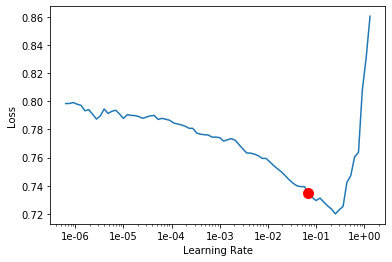

In [139]:
learn_c_bwd.lr_find()
learn_c_bwd.recorder.plot(suggestion=True)

In [131]:
lr=2e-2
lr *= 64/48
moms = (0.8,0.7)

In [140]:
learn_c_bwd.fit_one_cycle(2,lr,moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,0.534069,0.513730,0.791541,00:48
1,0.530423,0.512163,0.790534,00:43


In [141]:
learn_c_bwd.freeze_to(-2)
learn_c_bwd.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.509672,0.489401,0.811178,00:52
1,0.485791,0.482675,0.820242,00:55


In [142]:
learn_c_bwd.freeze_to(-3)
learn_c_bwd.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.479049,0.466325,0.822256,01:01
1,0.440144,0.460868,0.842397,01:14


In [143]:
learn_c_bwd.save('1a')

In [146]:
learn_c_bwd.unfreeze()
learn_c_bwd.fit_one_cycle(2, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.396842,0.471857,0.838872,01:16
1,0.367492,0.476664,0.826284,01:12


In [147]:
learn_c_bwd.load('general-clasifier-bwd-0.83');

In [266]:
def _get_individual_data(filepath):
    df = pd.read_csv(filepath)
    if df.shape[0]*0.7 < 64: 
        bs= int(df.shape[0]*0.7)
    else: bs=64
    data = (TextList
            .from_df(df=df,path=path,cols='Body',vocab=data_lm_bwd.vocab)
            .split_by_rand_pct(0.3,seed=42)
            .label_from_df(cols='Label')
            .databunch(bs=bs,num_workers=os.cpu_count()*4,backwards=True)
           )
    return data

def _get_individual_learner(data):
    learn = text_classifier_learner(data,AWD_LSTM,drop_mult=0.5,
                                loss_func=FlattenedLoss(LabelSmoothingCrossEntropy),
                                metrics=[accuracy], #FBeta(beta=1)
                                model_dir = path/'models'
                               )
    if torch.cuda.is_available():
        learn.to_fp16()
    learn.load('general-clasifier-bwd-0.83')
    learn.unfreeze()
    #learn.freeze_to(-1)
    return learn

def run_valid(data_path):
    _data_valid = _get_individual_data(data_path)
    _learn_valid = _get_individual_learner(_data_valid)
    _learn_valid.fit_one_cycle(1,2e-2,moms=(0.8,0.7))
    return _learn_valid.recorder.metrics[0][0].item()

In [267]:
%%time
bwd_valid_acc = []
for file in valid_list:
    bwd_valid_acc.append(run_valid(file))

epoch,train_loss,valid_loss,accuracy,time
0,0.386144,0.330070,0.959799,00:06


CPU times: user 1min 30s, sys: 1min 22s, total: 2min 53s
Wall time: 2min 56s


In [157]:
bwd_valid_acc

[0.6666666865348816,
 0.9583333134651184,
 0.7777777910232544,
 0.6153846383094788,
 0.7407407164573669,
 0.5625,
 0.6842105388641357,
 0.9743589758872986,
 0.8399999737739563,
 0.550000011920929,
 1.0,
 0.7948718070983887,
 0.6190476417541504,
 0.46153849363327026,
 0.9545454382896423,
 0.8160919547080994,
 0.8095238208770752,
 0.6071428656578064,
 0.9365079998970032,
 0.9189189076423645,
 0.9396985173225403]

In [158]:
sum(bwd_valid_acc) / 21

0.7727552425293696

In [268]:
bwd_valid_acc

[0.6666666865348816,
 0.9583333134651184,
 0.7777777910232544,
 0.6153846383094788,
 0.7407407164573669,
 0.5625,
 0.6315789222717285,
 0.9487179517745972,
 0.8399999737739563,
 0.6500000357627869,
 1.0,
 0.7692307829856873,
 0.6190476417541504,
 0.46153849363327026,
 0.9545454382896423,
 0.8045976758003235,
 0.8095238208770752,
 0.6071428656578064,
 0.6984127163887024,
 0.9189189076423645,
 0.9597989916801453]

In [269]:
sum(bwd_valid_acc) / 21

0.7616408268610636

In [161]:
valid_list[0]

PosixPath('/home/jupyter/insight_project/Project-M/data/preprocessed/csv/2a0a1cf7-29c1-4459-ab85-b57ed06386a7.csv')

In [249]:
data_valid_1 = _get_individual_data(valid_list[5])

In [250]:
learn_valid_1 = _get_individual_learner(data_valid_1)

In [252]:
learn_valid_1.unfreeze()
learn_valid_1.fit_one_cycle(3,2e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.661392,0.865231,0.593750,00:04
1,0.568596,1.441249,0.625000,00:04
2,0.470196,0.843599,0.687500,00:04


In [253]:
preds,y = learn_valid_1.get_preds()

In [254]:
preds.shape,y.shape

(torch.Size([32, 2]), torch.Size([32]))

In [255]:
accuracy(preds,y)

tensor(0.6875)

In [256]:
preds.argmax(dim=1)

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0])

In [257]:
y

tensor([0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 1, 0, 1, 1, 1, 1])